In [1]:
import math
import random
import matplotlib.pyplot as plt
from setuptools.command.test import test

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
def rand(a, b):
    return (b-a)*random.random() + a

In [4]:
def makeMatrix(I, J, fill=0.0):
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m

In [5]:
def sigmoid(x):
    #return math.tanh(x)
    return 1 / (1 + math.exp(-x))

In [6]:
def dsigmoid(y):
    #return 1.0 - y ** 2
    return (1-y)*y

In [7]:
def plot(inputs, outputs, actual):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(inputs, actual, 'b-')
    ax1.plot(inputs, outputs, 'r.')
    plt.draw()

In [8]:
def convert_result(prediction):
    result = []
    for value in prediction:
        if(value[0] > 0.8):
            result.append(1)
        else:
            result.append(0)
    return result

In [9]:
def read_data():
    data = pd.read_csv('heart2.csv', sep=",")

    data.sex = data.sex.astype('category')
    data.cp = data.cp.astype('category')
    data.fbs = data.fbs.astype('category')
    data.restecg = data.restecg.astype('category')
    data.exang = data.exang.astype('category')
    data.ca = data.ca.astype('category')
    data.slope = data.slope.astype('category')
    data.thal = data.thal.astype('category')
    
    return data

In [10]:
class NN:
    def __init__(self, ni, nh, no, regression = False):

        self.regression = regression

        #Number of input, hidden and output nodes.
        self.ni = ni  + 1 # +1 for bias node
        self.nh = nh  + 1 # +1 for bias node
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no

        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)

        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-1, 1)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-1, 1)

        # last change in weights for momentum
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)


    def forwardPropagate(self, inputs):

        if len(inputs) != self.ni-1:
            print(len(inputs), " -- ",self.ni-1)
            raise(ValueError,  'wrong number of inputs')

        # input activations
        for i in range(self.ni - 1):
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh - 1):
            total = 0.0
            for i in range(self.ni):
                total += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(total)

        # output activations
        for k in range(self.no):
            total = 0.0
            for j in range(self.nh):
                total += self.ah[j] * self.wo[j][k]
            self.ao[k] = total
            if not self.regression:
                self.ao[k] = sigmoid(total)


        return self.ao[:]


    def backPropagate(self, targets, N, M):
        if len(targets) != self.no:
            raise(ValueError, 'wrong number of target values')
        # calculate error terms for output


        output_deltas = [0.0] * self.no


        for k in range(self.no):

            output_deltas[k] = targets[k] - self.ao[k]
            if not self.regression:
                output_deltas[k] = dsigmoid(self.ao[k]) * output_deltas[k]


        # calculate error terms for hidden
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error += output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change
        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5*((targets[k]-self.ao[k])**2)
        return error


    def predict(self, test_x):
        prediction = []
        for p in test_x:
            prediction.append(self.forwardPropagate(p))
        
        result = convert_result(prediction)

        return result


    def weights(self):
        print('Input weights:')
        for i in range(self.ni):
            print(self.wi[i])
        print('Output weights:')
        for j in range(self.nh):
            print(self.wo[j])

    def train(self, train_x, train_y, iterations=1000, N=0.5, M=0.1, verbose = False):
        """Train the neural network.

        N is the learning rate.
        M is the momentum factor.
        """
        err = []
        for i in range(iterations):
            error = 0.0
            for x,y in zip(train_x,train_y):
                self.forwardPropagate(x)
                tmp = self.backPropagate(y, N, M)
                error += tmp
            if i % 50 == 0:
                print (i,'error %-14f' % error)
                err.append((i,error))
        
        return err;

In [11]:
def demoClassification(train_x,train_y):
    # create a network with two input, two hidden, and one output nodes
    model = NN(22,19 ,1, regression = False)

    # train it with some patterns then test it.
    err = model.train(train_x,train_y, 200, 0.001,0.001)
    
    return model, err

In [12]:
x = read_data()

In [14]:
y = x['target']
del x['target']

In [15]:
y = pd.DataFrame(y)
x = pd.get_dummies(x, drop_first=True)

In [16]:
data_scaled = StandardScaler().fit_transform(x)
data_scaled = pd.DataFrame(data=data_scaled, columns=x.columns)

/usr/local/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.20, random_state=42)

In [18]:
train_x = x_train.values.tolist()
train_y = y_train.values.tolist()

In [19]:
test_x = x_test.values.tolist()
test_y = y_test.values.tolist()

In [20]:
model, err = demoClassification(train_x,train_y)

0 error 27.621014     
50 error 19.441626     
100 error 16.975547     
150 error 15.574006     


In [21]:
error = []
_iter = []

In [22]:
for i,e in err:
    error.append(e)
    _iter.append(i)

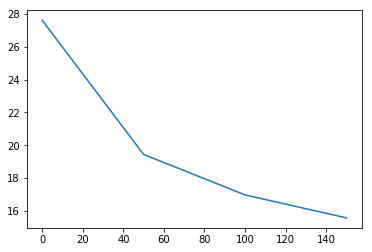

In [23]:
plt.plot(_iter[:800],error[:800])

In [26]:
result = model.predict(test_x)

In [27]:
c_matrix = confusion_matrix(test_y, result)

In [28]:
tn, fp, fn, tp = c_matrix.ravel()

In [29]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [30]:
precision, recall

(0.9375, 0.46875)

In [31]:
2 * precision * recall / (precision + recall)

0.625

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)
print("variance ratio:", pca.explained_variance_ratio_)

print("sum:", sum(pca.explained_variance_ratio_))
x["p1"] = x_pca[:, 0]
x["p2"] = x_pca[:, 1]

color = ["red", "green"]

for each in range(2):
    plt.scatter(x.p1[y.target == each], x.p2[y.target == each], color=color[each], label=y.target, alpha=0.5)

plt.xlabel("p1")
plt.ylabel("p2")
plt.show()